# March 2021 screen
### The following code is for cleaning, formatting and unblinding data in addition to a few exploratory figures
<p> For this screen we scaled up from ~40 test conditions to 96 test conditions. These include compounds from the HEAL pain grant, compounds identified as possible chemotaxis modulators from lit review, and some complex mixtures from essential oils using a single solvent, DMSO. The aim of this screen was to screen many different types of compounds against N2 animals only. We also implemented new code for the image analysis that no longer relied on background subtraction.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics

## Reading in the screen metadata and the image analysis results

In [39]:
screen_metadata = pd.read_csv('C:/Users/Emily/Documents/_2021_03_screen/NP_metadata_2103.csv')
ia_data = pd.read_csv('C:/Users/Emily/Documents/_2021_03_screen/_2021_03_automated_results/2103_screen.csv', index_col=0)

## Wrangling the data:

### 1. Connecting the image analysis data to the metadata

In [40]:
# Breaking up the slot and well info to use for unblinding the compound data
for index, row in ia_data.iterrows():
    ia_data['Slot']= ia_data['WellNo'].astype(str).str[0]
    ia_data['Well']= ia_data['WellNo'].astype(str).str[1]

In [41]:
# Adding the plate ID to the image analysis results
def add_pid(row, image_metdat):
    pid = image_metdat.loc[(image_metdat['Image ID']==row['File Name']) 
                           & (image_metdat['Scanner Slot:'].astype(str)==row['Slot'])]['Plate ID']
    return pid.values[0]

ia_data['Plate ID']=ia_data.apply(
    lambda row: add_pid(row, screen_metadata), axis=1)
ia_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well
0,1A,68.0,0.482759,NaN,NaN,NPP_210329_POST_004,NPP_210329_013,1,A
1,1B,129.0,0.529412,NaN,NaN,NPP_210329_POST_004,NPP_210329_013,1,B
2,1C,91.0,0.552941,NaN,NaN,NPP_210329_POST_004,NPP_210329_013,1,C
3,1D,112.0,0.524752,NaN,NaN,NPP_210329_POST_004,NPP_210329_013,1,D
4,2A,120.0,-0.220000,NaN,NaN,NPP_210329_POST_004,NPP_210329_014,2,A


In [42]:
# Creating a function to map the compound key to the automated image analysis
# results
def f(x):
    return {
        'A': 'Compound A Blind',
        'B': 'Compound B Blind',
        'C': 'Compound C Blind',
        'D': 'Compound D Blind',
    }[x]

def add_compound(row, image_metdat):
    well=row['Well']
    dat = image_metdat.loc[image_metdat['Plate ID']==row['Plate ID']][f(well)]
    return dat.values[0]

ia_data['Compound']=ia_data.apply(
    lambda row: add_compound(row, screen_metadata), axis=1)

#ia_data.to_csv('/Volumes/LaCie/_2021_03_screen/2103_data.csv')

### 2. Unblinding
<p> All of the compounds were blinded to the experimenters during the screen so we need to unblind them using the compound key </p>

In [43]:
# Reading in the compound blinding key
compound_key = pd.read_csv('C:/Users/Emily/Documents/_2021_03_screen/2103_compound_key.csv')
compound_key.head()

,Plate,Compound Well,Compound Name,Number Assigned to Compound
0,1-1,B2,Alyssin,1
1,1-1,B3,Furfural,2
2,1-1,B4,3-Carene,3
3,1-1,B5,Eucalyptol,4
4,1-1,C2,R(-)-Carvone,5


In [44]:
#Generating a function to add the unblinded compound names to the image analysis data
def add_compound_name(row, compound_key_data):
    compound = compound_key_data.loc[
        compound_key_data['Number Assigned to Compound']==row['Compound']]['Compound Name']
    return compound.values[0]

ia_data['Compound Name'] = ia_data.apply(
    lambda row: add_compound_name(row, compound_key), axis=1).astype('category')
ia_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
0,1A,68.0,0.482759,49,NaN,NPP_210329_POST_004,NPP_210329_013,1,A,Ethyl Levulinate
1,1B,129.0,0.529412,50,NaN,NPP_210329_POST_004,NPP_210329_013,1,B,Vincristine Sulfate Salt
2,1C,91.0,0.552941,51,NaN,NPP_210329_POST_004,NPP_210329_013,1,C,Phenyl Acetylene
3,1D,112.0,0.524752,52,NaN,NPP_210329_POST_004,NPP_210329_013,1,D,δ-Aminolevulinic Acid
4,2A,120.0,-0.220000,21,NaN,NPP_210329_POST_004,NPP_210329_014,2,A,(+)-β-Citronellene


### 3. Cleaning the data
<p> There is the possibility that some of the compounds were mixed up when added to assay plates NPP_210322_001 - 012. The experiment was repeated for these plates on 210329 and the replacement plate numbers are NPP_210329_001 - 012. Additionally, a similar mix up may have occured on plates NPP_210325_018 and NPP_210325_019. These plates were similarly rescreened and replaced by plate IDs NPP_210329_013 and NPP_210329_014. 
    
As a result we have removed the data from the "mistake" plates and added in the data from the repeated assay. </p>

In [73]:
### Write a little bit of code that removes the "bad" data 
### instead of removing the data manually
unblinded = ia_data.copy()

def remove_mistake(metadata):
    for i in range(1,13):
        if i < 10:
            p = "00" + str(i)
        else:
            p = "0" + str(i)
        mistake = "NPP_210322_" + p
        metadata = metadata.drop(metadata[metadata['Plate ID'] == mistake].index)
        return metadata


cleaned_data = remove_mistake(unblinded)
cleaned_data = cleaned_data.sort_values(by=['Plate ID'])
cleaned_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
7,2D,241.0,0.393617,32,NaN,NPP_210319_POST_001,NPP_210319_002,2,D,p-Anisic Acid
6,2C,173.0,0.390728,31,NaN,NPP_210319_POST_001,NPP_210319_002,2,C,Rotenone
5,2B,223.0,-0.144444,30,NaN,NPP_210319_POST_001,NPP_210319_002,2,B,Geranyl Acetate
4,2A,166.0,-0.343750,29,NaN,NPP_210319_POST_001,NPP_210319_002,2,A,Ethyl Palmitate
11,3D,188.0,-0.259740,36,NaN,NPP_210319_POST_001,NPP_210319_003,3,D,Carvacrol


In [48]:
# Filtering for replicates with total worm counts that meet our criteria of >150 and 300< 
total_worms = unblinded.loc[(unblinded['Total Worms'] >= 150) & (unblinded['Total Worms'] <= 300)].reset_index(drop=True)

#We want to count how many replicates met the above criteria
total_worms['freq'] = total_worms.groupby('Compound')['Compound'].transform('count').reset_index(drop=True)
comp_counts=(total_worms.drop_duplicates(['Compound', 'Compound Name']))

#comp_counts.to_csv('/Volumes/LaCie/_2021_03_screen/compound_counts.csv')
cleaned_comp_counts = comp_counts[['Compound', 'Compound Name', 'freq']].copy()
cleaned_comp_counts.head()

,Compound,Compound Name,freq
0,81,Micheliolide,4
1,82,Maslinic Acid,4
2,83,(-)-Deguelin,4
3,84,Leonurine,2
4,88,Spinosad,3


In [49]:
#Compounds that had no replicates that met our criteria were accidently eliminated from the list
#above and needed to be added back in
df2 = {'Compound': 60, 'Compound Name': 'Phytol', 'freq': 0}
df3 = {'Compound': 90, 'Compound Name': 'Carnosol', 'freq': 0}
cleaned_comp_counts = cleaned_comp_counts.append([df2,df3], ignore_index = True)
cleaned_comp_counts.tail()

,Compound,Compound Name,freq
92,96,Empty,2
93,67,Oleanolic Acid,2
94,49,Ethyl Levulinate,2
95,60,Phytol,0
96,90,Carnosol,0


In [50]:
#Filtering the dataframe above to identify where we need to make up for conditions that do not have
#a total of 3 biological replicates
missing_reps = cleaned_comp_counts.loc[cleaned_comp_counts['freq'] < 3]
missing_reps['To repeat'] = missing_reps.apply(
    lambda row: 3 - row['freq'], axis=1)
total_reps = missing_reps['To repeat'].sum()
total_reps

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Generating plots and performing statistical analysis on dataset

In [79]:
summary_stats = pd.DataFrame({'Max Worms' : cleaned_data.groupby( ["Compound"])['Total Worms'].max(),
                       'Min Worms' : cleaned_data.groupby( ["Compound"])['Total Worms'].min(),
                       'Mean CI' : cleaned_data.groupby( ["Compound"])['Chemotaxis'].mean(),
                        'SD CI' : cleaned_data.groupby( ["Compound"])['Chemotaxis'].std(),
                       'Compound Count' : cleaned_data.groupby( ["Compound"] ).size(),}).reset_index()

zscore = lambda x: (x - x.mean()) / x.std()
cleaned_data.insert(5, 'z-score', cleaned_data.groupby(['Compound'])['Chemotaxis'].transform(zscore))

cleaned_data['zscore'] = (cleaned_data.Chemotaxis - cleaned_data.Chemotaxis.mean())/cleaned_data.Chemotaxis.std(ddof=0)

values_plus_minus_one_z_score = len(cleaned_data[cleaned_data['z-score'].between(-1, 1)==True])
percent_values_plus_minus_one_z_score = values_plus_minus_one_z_score/len(cleaned_data)*100

cleaned_data = cleaned_data.sort_values(by='Chemotaxis', ascending = False).reset_index(drop=True)

plot_order = cleaned_data['Compound'].unique().tolist()

In [80]:
summary_stats.head()

,Compound,Max Worms,Min Worms,Mean CI,SD CI,Compound Count
0,5,197.0,101.0,-0.211268,0.278859,2
1,6,265.0,95.0,0.704736,0.205435,2
2,7,158.0,131.0,0.709647,0.026764,2
3,8,163.0,96.0,0.685061,0.046510,2
4,9,278.0,158.0,0.105001,0.120941,3


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


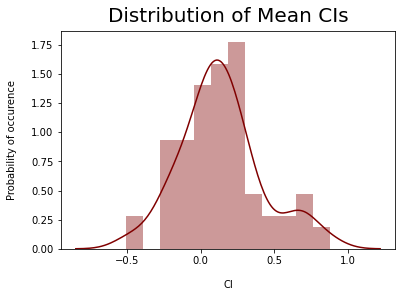

In [76]:
sns.distplot(summary_stats['Mean CI'], color="maroon")
plt.xlabel("CI", labelpad=14)
plt.ylabel("Probability of occurence", labelpad=14)
plt.title("Distribution of Mean CIs", y=1.015, fontsize=20);

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


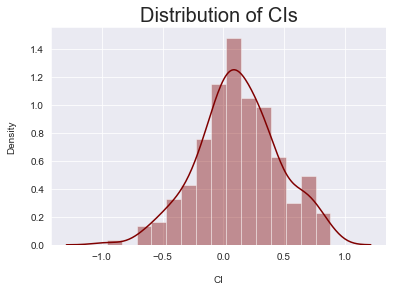

In [116]:
sns.set_style('darkgrid')
sns.distplot(cleaned_data['Chemotaxis'], color="maroon", kde=True)
plt.xlabel("CI", labelpad=14)
plt.ylabel("Density", labelpad=14)
plt.title("Distribution of CIs", y=1, fontsize=20);
#plt.savefig('/Volumes/LaCie/_2021_03_screen/CI_dist.png')

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


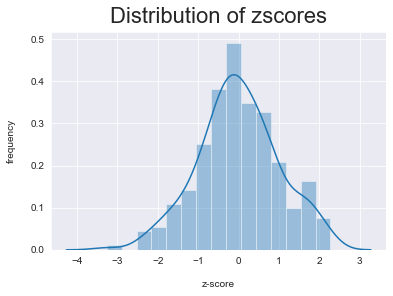

In [81]:
sns.set_style('darkgrid')
sns.distplot(cleaned_data['zscore'])
#cleaned_data['zscore'].hist(color='slategray')
plt.title("Distribution of zscores", y=1.015, fontsize=22)
plt.xlabel("z-score", labelpad=14)
plt.ylabel("frequency", labelpad=14);
#plt.savefig('/Volumes/LaCie/_2021_03_screen/zscore_dist.png')

Text(0, 0.5, 'frequency')

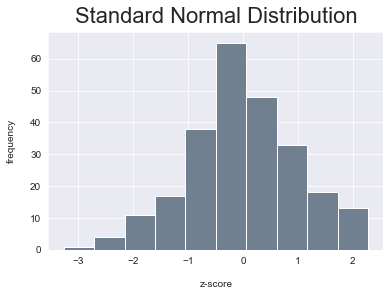

In [83]:
#sns.distplot(cleaned_data['Chemotaxis'])
cleaned_data['zscore'].hist(color='slategray')
plt.title("Standard Normal Distribution", y=1.015, fontsize=22)
plt.xlabel("z-score", labelpad=14)
plt.ylabel("frequency", labelpad=14);
#plt.savefig('/Volumes/LaCie/_2021_03_screen/zscore_hist.png')

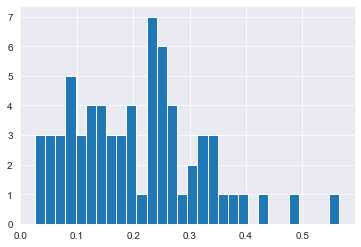

In [84]:
plt.hist(summary_stats['SD CI'], bins=30)
plt.show()

In [85]:
cv = pd.DataFrame({'Coefficient of Variance' : cleaned_data.groupby(['Compound'])['Chemotaxis'].std() / cleaned_data.groupby(['Compound'])['Chemotaxis'].mean().abs()})
merged_df = pd.merge(left=summary_stats, right=cv, left_on='Compound', right_on='Compound').reset_index(drop=True)


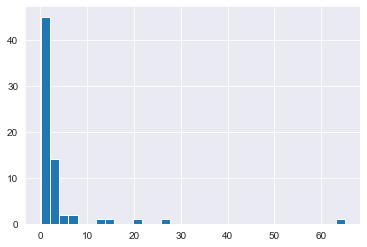

In [86]:
plt.hist(merged_df['Coefficient of Variance'], bins=33)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text

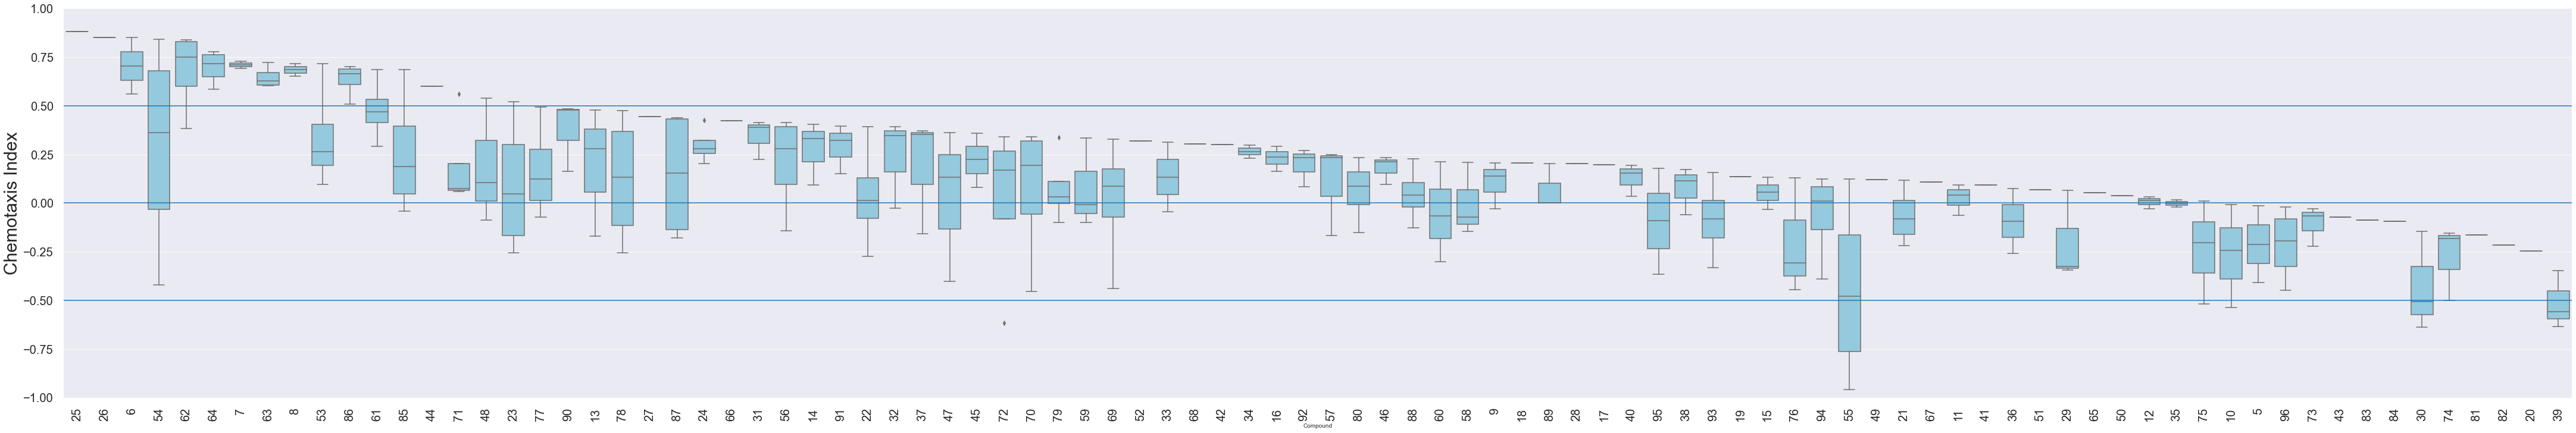

In [92]:
fig, ax = plt.subplots(figsize=(60, 10), constrained_layout=True)
sns.boxplot(x='Compound', y='Chemotaxis', ax=ax,
              data=cleaned_data, color='skyblue', dodge=False, order=plot_order)
#ax.set_xlabel('Compound', fontsize=30)
ax.set_ylabel('Chemotaxis Index', fontsize=30)

ax.set_ylim((-1, 1))
ax.tick_params(labelsize=20)
ax.axhline(.5)
ax.axhline(-.5)
ax.axhline(0)
sns.despine(offset=10)
plt.xticks(rotation=90)


In [131]:
control_list = ['DMSO', 'Empty', 'R(-)-Carvone', 'R(+)-Carvone', '2-Nonanone','Isoamyl Alcohol', 'Diacetyl']
#control_sumdat = merged_df[merged_df['Compound'].isin(control_list)].reset_index(drop=True)
controls = cleaned_data[cleaned_data['Compound Name'].isin(control_list)].reset_index(drop=True)
#controls.to_csv('/Volumes/LaCie/_2021_03_screen/control_data.csv')
controls

,WellNo,Total Worms,Chemotaxis,Compound,Strain,z-score,File Name,Plate ID,Slot,Well,Compound Name,zscore
0,3A,243.0,0.881818,25,NaN,NaN,NPP_210322_POST_005,NPP_210322_019,3,A,Isoamyl Alcohol,2.275186
1,2B,286.0,0.841004,54,NaN,0.981490,NPP_210322_POST_001,NPP_210322_002,2,B,2-Nonanone,2.152421
2,4B,202.0,0.837838,62,NaN,0.740835,NPP_210322_POST_001,NPP_210322_004,4,B,Diacetyl,2.142897
3,4B,121.0,0.827586,62,NaN,0.692566,NPP_210329_POST_001,NPP_210329_004,4,B,Diacetyl,2.112061
4,2B,242.0,0.674208,62,NaN,-0.029607,NPP_210325_POST_006,NPP_210325_022,2,B,Diacetyl,1.650712
5,4B,211.0,0.627660,54,NaN,0.604245,NPP_210325_POST_005,NPP_210325_020,4,B,2-Nonanone,1.510698
6,4B,315.0,0.382353,62,NaN,-1.403794,NPP_210319_POST_005,NPP_210319_016,4,B,Diacetyl,0.772835
7,4D,277.0,0.195312,40,NaN,0.804623,NPP_210325_POST_001,NPP_210325_004,4,D,DMSO,0.210233
8,2D,267.0,0.154185,40,NaN,0.314931,NPP_210322_POST_006,NPP_210322_022,2,D,DMSO,0.086525
9,4C,72.0,0.122807,55,NaN,1.193764,NPP_210325_POST_005,NPP_210325_020,4,C,R(+)-Carvone,-0.007858


In [126]:
control_order = ['DMSO', 'Empty', 'R(-)-Carvone', 'R(+)-Carvone', '2-Nonanone','Isoamyl Alcohol', 'Diacetyl' ] 

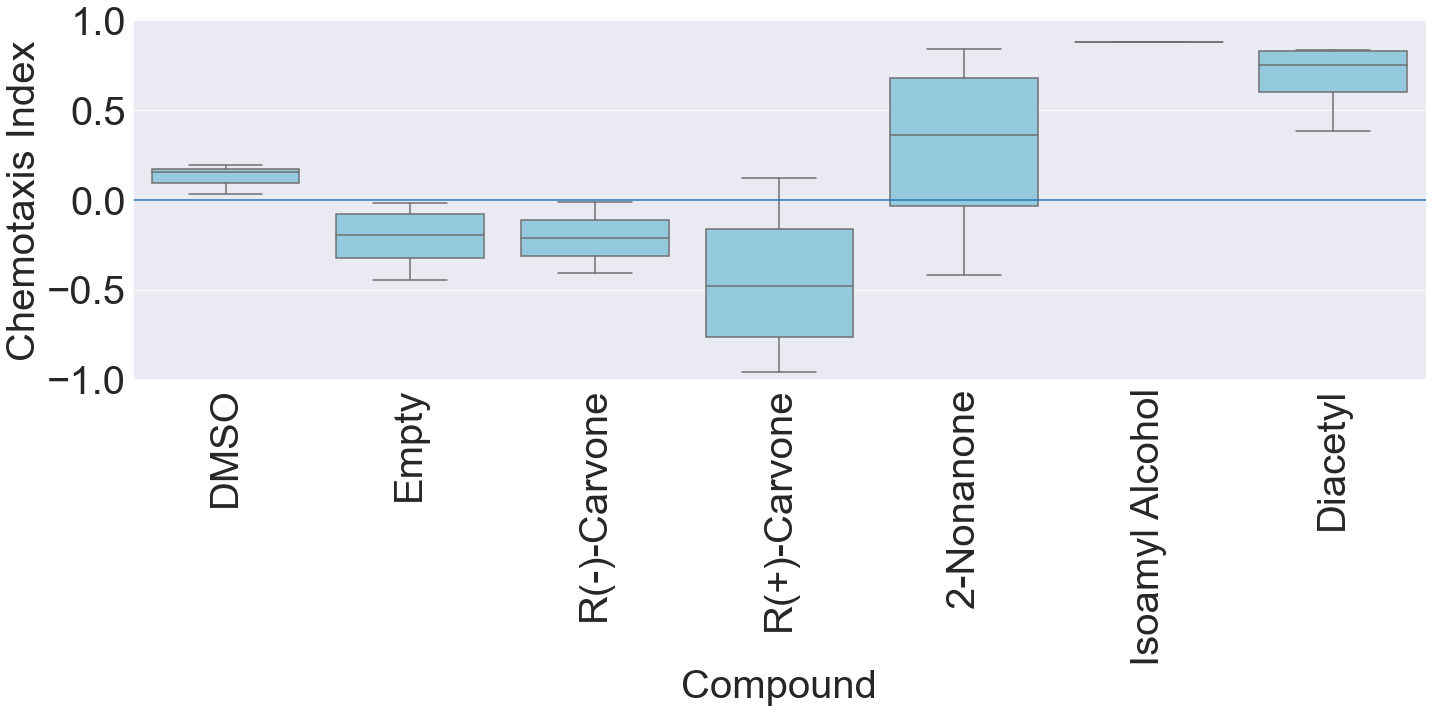

In [138]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Compound Name', y='Chemotaxis', color='skyblue', data=controls, order=control_order)
ax.set_xlabel('Compound', fontsize=40)
ax.set_ylabel('Chemotaxis Index', fontsize=40)

ax.set_ylim((-1, 1))
ax.tick_params(labelsize=40)
ax.axhline(0)
#sns.despine(offset=10)
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig('/Volumes/LaCie/_2021_03_screen/Controls.png')


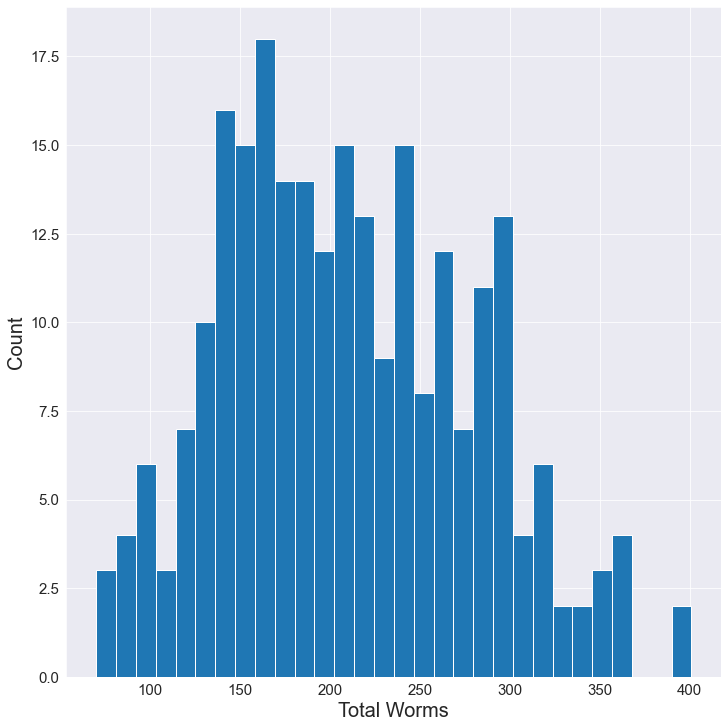

In [117]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
plt.hist(cleaned_data['Total Worms'], bins=30)
ax.set_xlabel('Total Worms', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.tick_params(labelsize=15)

#plt.savefig('/Volumes/LaCie/_2021_03_screen/worm_dist.png')

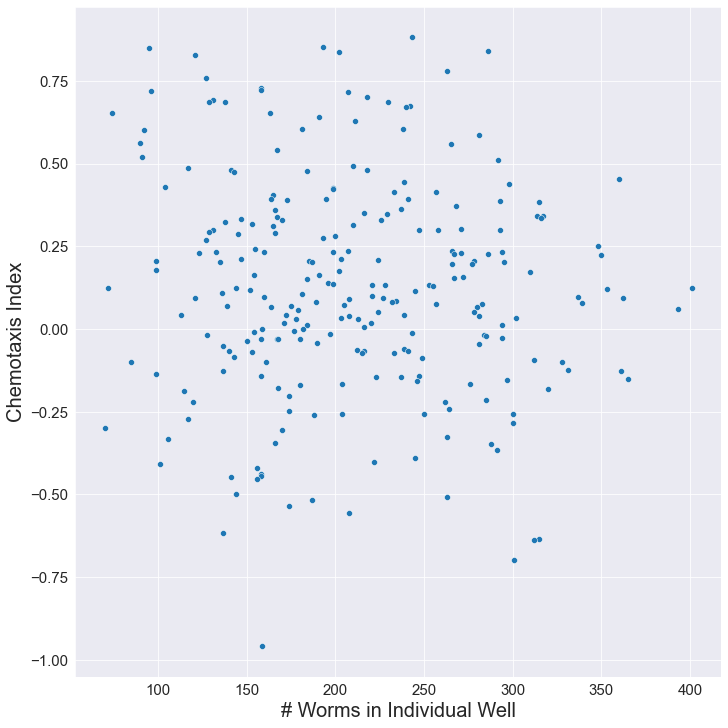

In [118]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
#plt.hist(merged_df['Coefficient of Variance'], bins=30)
sns.scatterplot(x=cleaned_data['Total Worms'], y=cleaned_data['Chemotaxis'])
ax.set_xlabel('# Worms in Individual Well', fontsize=20)
ax.set_ylabel('Chemotaxis Index', fontsize=20)
ax.tick_params(labelsize=15)

#plt.savefig('/Volumes/LaCie/_2021_03_screen/CI_totalworms.png')

LinregressResult(slope=-0.00039117089067156855, intercept=0.20757319257026186, rvalue=-0.08089994024187083, pvalue=0.20420603578546276, stderr=0.0003072733661733687)


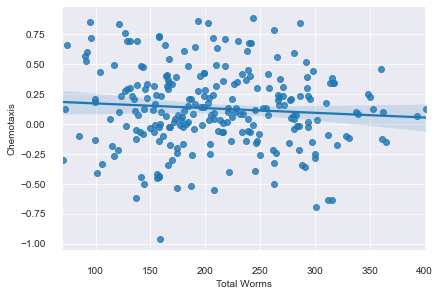

In [119]:
fig, ax = plt.subplots(constrained_layout=True)
sns.regplot(x='Total Worms', y='Chemotaxis', ax=ax,
                     data=cleaned_data)
#ax.set_ylabel('# worms (machine)')
#ax.set_xlabel('# worms (manual)')
sns.despine(offset=10)
#fig.savefig(base_folder.joinpath('total_worms_man_vs_machine.pdf'))

fit_results = stats.linregress(
    cleaned_data['Total Worms'], cleaned_data['Chemotaxis'])
print(fit_results)

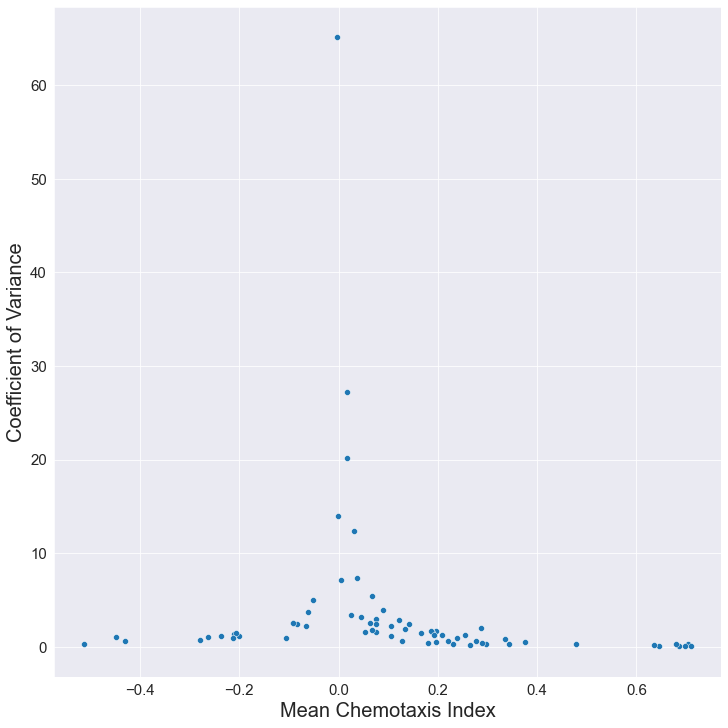

In [120]:
fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)
#plt.hist(merged_df['Coefficient of Variance'], bins=30)
sns.scatterplot(x=merged_df['Mean CI'], y=merged_df['Coefficient of Variance'])
ax.set_xlabel('Mean Chemotaxis Index', fontsize=20)
ax.set_ylabel('Coefficient of Variance', fontsize=20)
ax.tick_params(labelsize=15)
#plt.savefig('/Volumes/LaCie/_2021_03_screen/CV_CImeans.png')